In [1]:
c = 3e8  # speed of light (m/s)
fc = 10e9  # Carrier frequency: 10 GHz
wavelength = c / fc
bandwidth = 100e6  # 100 MHz
tx_power_dbm = 50  #  75 W- 100W 48.75-50.00 dBm
jam_power_dbm = 70
k = 1.38e-23  # Boltzmann 
GT = 13 # db gain-to-noise-temperature for for 0.33m Equivalent satellite antenna aperturesatellites, or can be 5 dB K^(-1) for 0.13m Equivalent satellite antenna aperture
La = 5 # dB
GT_linear_inv = 10 ** (-GT / 10)
La_linear = 10 ** (La / 10)
noise_power_watt = k * bandwidth * GT_linear_inv * La_linear
Tx_power_watt = 10 ** ((tx_power_dbm  - 30)/ 10)  
Jam_power_watt = 10 ** ((jam_power_dbm  - 30)/ 10)

N0 = noise_power_watt

T_sys = 300.0  # K  realistic mid-value for LEO sat RX
N0 = 1.38e-23 * 100e6 * T_sys*La_linear
P0 = Tx_power_watt
P1 = Jam_power_watt


In [2]:
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu, compute_az_el_dist
import numpy as np

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from minmax_solvers import (
    solve_game_bestresp_Q0_then_Q1,
    compute_J
)
from CloseBF import jammeraware_Q
from Dishjammersolver import optimal_Q0
from leo_utils import arc_point_on_earth, compute_satellite_intersection_point_enu
from sionna.rt import PlanarArray
from numpy.linalg import cholesky, solve, eigh


# Generate RX positions
jam_dist = 1
# distances_km = [5,15,10,20]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist,jam_dist]
# distances_km = [jam_dist,jam_dist,jam_dist,jam_dist]
distances_km = [jam_dist]
azimuths_deg = np.linspace(0, 360, len(distances_km), endpoint=False)
gnd_positions = [np.array([0.0, 0.0, 0.0])]

for d_km, az in zip(distances_km, azimuths_deg):
    pos = arc_point_on_earth(d_km, az)
    gnd_positions.append(pos)
gnd_positions = np.array(gnd_positions)

for i, pos in enumerate(gnd_positions):
    print(f"TX{i}(m): {pos}")


# Compute SAT intersection points

# sat_orbit_m = 500e3
# # angles = [(1, 90-(1e-9))]
# # angles = [(45, 50-(1e-3)), (120, 47), (180,80), (165, 72),(230,50)]
# # angles = [(50, 70-(1e-3)), (130,70)]
# angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(345.49,65.65), (272.81, 60.03)]
# # angles = [(117.88, 56.2),(230.22, 72.96), (198,60.5),(305.49,65.65), (272.81, 60.03)]
# # angles = [(117.88, 66.2),(200.22, 62.96), (248,57.5),(355.49,57.65), (20.81, 57.03)]
# sat_positions = []
# delays_ms = []
# fspl_db = []
# frequency_hz = 10e9 
# wavelength = 3e8 / frequency_hz

# for az, el in angles:
#     pos, delay, dist = compute_satellite_intersection_point_enu(az, el, sat_orbit_m)
#     sat_positions.append(pos)
#     delays_ms.append(delay)
#     fspl = 20 * np.log10(4 * np.pi * dist / wavelength)
#     fspl_db.append(fspl)

# sat_positions = np.array(sat_positions)
# delays_ms = np.array(delays_ms)
# fspl_db = np.array(fspl_db)

# print("\nSatellite Pos [m]:\n", sat_positions)
# # print("\nPropagation delays [ms]:\n", delays_ms)
# # print("\nFree-space path loss [dB]:\n", fspl_db)


# # Compute az/el/dist per TX-SAT
  
# for i, tx in enumerate(gnd_positions):
#     print(f"\nFrom TX{i}:")
#     for j, sat in enumerate(sat_positions):
#         az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
#         print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")


jitc_llvm_init(): LLVM API initialization failed ..


TX0(m): [0. 0. 0.]
TX1(m): [ 6.12323397e-14  9.99999996e+02 -7.84806153e-02]


In [3]:
# %%
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

def best_time_for_k(jsonl_path: str | Path, m: int, n: int = 1, distinct: bool = True):
    """
    Find the times corresponding to the n-th largest J_last for k = m.

    Args:
        jsonl_path: path to JSONL file.
        m:         target k value.
        n:         rank to select (1 = largest).
        distinct:  if True, rank by distinct value levels (recommended).
                   if False, rank by entry order after sorting (allows duplicates to occupy multiple ranks).

    Returns:
        (selected_times, selected_value, ranking_basis)
        - selected_times: list of times tied at the selected value
        - selected_value: the numeric J_last value at rank n
        - ranking_basis:  sorted list used for ranking (distinct or full list)
    """
    jsonl_path = Path(jsonl_path)

    vals, times = [], []
    with jsonl_path.open("r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            obj = json.loads(line)
            if int(obj.get("k", -1)) != int(m):
                continue
            J_series = obj.get("hist", {}).get("J", [])
            if not J_series:
                continue
            last_val = float(np.real(J_series[-1]))
            vals.append(last_val)
            times.append(obj.get("time"))

    if not vals:
        print(f"[Info] No entries found for k={m}.")
        return [], None, []

    # Build the ranking basis
    if distinct:
        basis = sorted(set(vals), reverse=True)
    else:
        basis = sorted(vals, reverse=True)

    if n < 1 or n > len(basis):
        print(f"[Info] Rank n={n} is out of range (available ranks: 1..{len(basis)}).")
        return [], None, basis

    target_value = basis[n-1]
    # All times tied at that value
    selected_times = [t for v, t in zip(vals, times) if v == target_value]

    print(f"✅ k={m}, rank n={n} ({'distinct' if distinct else 'non-distinct'})")
    print(f"   Selected J_last value: {target_value}")
    print(f"   Matching times: {selected_times}")

    return selected_times, target_value, basis

# ---- You already have ----
# selected_times, target_value, _ = best_time_for_k("allarray7km.jsonl", m=5, n=2, distinct=True)
csv_path = Path("starlink_randtimepoint_400.csv")  # adjust path if needed
frequency_hz = 10e9
c = 3e8
wavelength = c / frequency_hz

# ---- Helper ----
def top5_sats_for_time(df: pd.DataFrame, time_str: str):
    # Parse times to pandas datetime for robust comparison
    df["Time"] = pd.to_datetime(df["Time"], errors="coerce")
    time_query = pd.to_datetime(time_str, errors="coerce")

    # Filter for exact same time (within 1 second tolerance just in case)
    tdf = df[np.abs((df["Time"] - time_query).dt.total_seconds()) < 1.0].copy()
    if tdf.empty:
        print(f"[WARN] No rows found for Time ≈ '{time_str}'")
        return None

    # Sort by Slant km (ascending = nearer) and take top 5
    tdf = tdf.sort_values("Slant km", ascending=True).head(5).reset_index(drop=True)

    positions = [
        np.array([row["x_East (m)"], row["y_North (m)"], row["z_Up (m)"]], dtype=float)
        for _, row in tdf.iterrows()
    ]
    azel = list(zip(tdf["Azimuth (°)"].astype(float), tdf["Elevation (°)"].astype(float)))
    names = tdf["Name"].astype(str).tolist()
    dist_m = (tdf["Slant km"].astype(float).to_numpy() * 1000.0)
    delays_ms = (dist_m / c) * 1e3
    fspl_db = 20.0 * np.log10(4.0 * np.pi * dist_m / wavelength)

    return {
        "time": str(time_query),
        "names": names,
        "positions": positions,
        "az_el_deg": azel,
        "dist_m": dist_m,
        "delays_ms": delays_ms,
        "fspl_db": fspl_db,
        "table": tdf,
    }
# ==== 自动绘制 From TX0 的五颗卫星在极坐标图上 (E→CCW) ====
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def compute_az_el_dist_math(sat_pos, gnd_pos, frequency_hz: float | None = None):
    """
    返回 az_eccw (E-CCW)、el_deg、dist 以及（可选）n_waves。
    注意：这与 compute_az_el_dist 的 North-CW 输出不同；这是给绘图/steering 用的。
    """
    vec  = sat_pos - gnd_pos
    dist = float(np.linalg.norm(vec))
    dx, dy, dz = vec / (dist + 1e-15)
    el_rad  = np.arcsin(dz)
    az_east = np.arctan2(dy, dx)                              # 0°=East, CCW
    az_eccw = (np.degrees(az_east) + 360.0) % 360.0
    el_deg  = float(np.degrees(el_rad))
    if frequency_hz is not None:
        wavelength = 3e8 / frequency_hz
        n_waves = dist / wavelength
        return az_eccw, el_deg, dist, n_waves
    return az_eccw, el_deg, dist


def make_sat_azel_for_tx_math(tx_pos, sat_positions, freq_hz):
    """为绘图/steering 构造卫星角度（E-CCW）。"""
    out = []
    for sat in sat_positions:
        az_eccw, el_deg, _, _ = compute_az_el_dist_math(sat, tx_pos, freq_hz)
        out.append((az_eccw, max(0.0, min(90.0, el_deg))))
    return out


In [4]:

# ---- Load once ----
df = pd.read_csv(csv_path)

selected_times, target_value,_ = best_time_for_k("allarray1km.jsonl", m=3, n=5, distinct=True) # 135, 153




✅ k=3, rank n=5 (distinct)
   Selected J_last value: 0.8776652027801073
   Matching times: ['2025-10-30T02:01:25']


Time used: 2025-10-30 02:01:25
Top-5 satellites (nearest by Slant km):
  #1: STARLINK-31315 | Slant=  478.20 km | az= 114.74°, el= 76.09° | x=104373.0 m, y=-48104.5 m, z=464190.3 m
  #2: STARLINK-11419 [DTC] | Slant=  485.70 km | az=  34.04°, el= 45.58° | x=190321.6 m, y=281731.6 m, z=346913.0 m
  #3: STARLINK-34332 | Slant=  486.50 km | az= 106.37°, el= 77.65° | x=99865.7 m, y=-29328.0 m, z=475234.0 m
  #4: STARLINK-34727 | Slant=  491.10 km | az= 225.93°, el= 75.33° | x=-89330.1 m, y=-86479.9 m, z=475090.4 m
  #5: STARLINK-31583 | Slant=  520.80 km | az= 146.28°, el= 67.44° | x=110905.9 m, y=-166149.1 m, z=480933.2 m

From TX0:
  SAT0: az=335.26°, el=76.09°, dist=478205.40 m, λ count ≈ 15940179.86
  SAT1: az=55.96°, el=45.58°, dist=485740.30 m, λ count ≈ 16191343.21
  SAT2: az=343.63°, el=77.65°, dist=486498.35 m, λ count ≈ 16216611.66
  SAT3: az=224.07°, el=75.33°, dist=491090.14 m, λ count ≈ 16369671.42
  SAT4: az=303.72°, el=67.44°, dist=520770.95 m, λ count ≈ 17359031.75

From TX

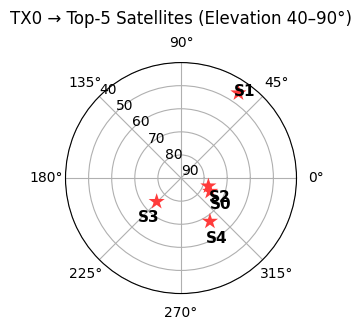

In [5]:

if not selected_times:
    raise ValueError("selected_times is empty. Run best_time_for_k() first.")
time_use = selected_times[0]

res = top5_sats_for_time(df, time_use)
if res is None:
    raise ValueError(f"No satellites found for time={time_use}")

# ---- Replace your sat_positions / delays / etc ----
sat_positions = res["positions"]
delays_ms     = res["delays_ms"].tolist()
fspl_db       = res["fspl_db"].tolist()
sat_names     = res["names"]
sat_az_el     = res["az_el_deg"]

print(f"Time used: {res['time']}")
print("Top-5 satellites (nearest by Slant km):")
for i, (nm, pos, (az, el), d_km) in enumerate(zip(
        sat_names, sat_positions, sat_az_el, res["dist_m"]/1000.0)):
    print(f"  #{i+1}: {nm:>12s} | Slant={d_km:8.2f} km | az={az:7.2f}°, el={el:6.2f}° | "
          f"x={pos[0]:.1f} m, y={pos[1]:.1f} m, z={pos[2]:.1f} m")
for i, tx in enumerate(gnd_positions):
    print(f"\nFrom TX{i}:")
    for j, sat in enumerate(sat_positions):
        az, el, dist, n_waves = compute_az_el_dist(sat, tx, frequency_hz)
        print(f"  SAT{j}: az={az:.2f}°, el={el:.2f}°, dist={dist:.2f} m, λ count ≈ {n_waves:.2f}")     
        
        
# 自动计算 E-CCW 方位角和仰角
sat_az_el_tx0 = make_sat_azel_for_tx_math(gnd_positions[0], sat_positions, frequency_hz)
sat_az_el_tx0 = sat_az_el_tx0[:5]  # 只画前5颗
sat_names = [f"S{i}" for i in range(len(sat_az_el_tx0))]

# === 绘图 ===
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111, projection="polar")

# 极坐标配置（E→CCW；仰角40–90°）
ax.set_theta_zero_location("E")
ax.set_theta_direction(1)
ax.set_rlim(90, 40)
ax.set_rlabel_position(135)
ax.set_title("TX0 → Top-5 Satellites (Elevation 40–90°)", va="bottom", fontsize=12)
# 绘制红色无边五角星，并在外侧标注 S0–S4
for i, (az_deg, el_deg) in enumerate(sat_az_el_tx0):
    az_r = np.deg2rad(az_deg)
    ax.scatter(az_r, el_deg, s=150, marker="*", color="#FF3B3B", edgecolors="none", zorder=4)
    # 标签略远一些（减小重叠），白色字体
    ax.text(az_r, el_deg - 5.0, sat_names[i], ha="center", va="top",
            color="black", fontsize=11, zorder=5, weight="bold")

# 保存与展示
out_dir = Path("result_plot")
out_dir.mkdir(parents=True, exist_ok=True)
fig.savefig(out_dir / "tx0_top5_satellites_polar.png", dpi=300, bbox_inches="tight")
fig.savefig(out_dir / "tx0_top5_satellites_polar.pdf", dpi=300, bbox_inches="tight")

plt.show()


In [6]:
from sionna.rt import Receiver, Transmitter, PlanarArray, PathSolver, load_scene
import numpy as np
import vsat_dish_3gpp


def compute_cir(tx_pos, rx_pos, tx_array, rx_array,tx_look_at, rx_look_at, frequency=10e9):
    """
    Compute CIR from a single transmitter to multiple receivers using synthetic arrays.
    
    Args:
        tx_pos:        (3,) list or np.array for transmitter position
        rx_pos_array:  (m,3) array of receiver positions
        tx_array:      PlanarArray for the transmitter
        rx_array:      PlanarArray for all receivers (shared)
        frequency:     Frequency in Hz

    Returns:
        a_list:    list of CIR amplitude arrays, one per RX
        tau_list:  list of delay arrays, one per RX
    """
    scene = load_scene()
    scene.frequency = frequency
    scene.synthetic_array = True
    
    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 

    # Add transmitter
    scene.tx_array = tx_array
    tx = Transmitter(name="tx", position=tx_pos, display_radius=200)
    scene.add(tx)
    
    earth_radius_m = 6371e3
    rx_look_at2 = np.array([0.0, 0.0, -1*earth_radius_m/2])
    
    if isinstance(tx_look_at, str) and tx_look_at.lower() in ["up-z", "up", "z"]:
        tx_look_at = np.array(tx_pos) + np.array([0.0, 0.0, 100000.0])
    tx.look_at(tx_look_at)
    # Add receivers
    scene.rx_array = rx_array
    rx_list = []
    for i, rx_pos in enumerate(rx_pos):
        rx = Receiver(name=f"rx{i}", position=rx_pos)
        scene.add(rx)
        rx.look_at(rx_look_at2)
        rx_list.append(rx)
    tx.look_at( tx_look_at)

    # Solve paths
    solver = PathSolver()
    paths = solver(scene=scene,
                   max_depth=0,
                   los=True,
                   synthetic_array=True,
                #    seed=41
                   )

    # Get CIRs
    a_all, tau_all = paths.cir(normalize_delays=False, out_type="numpy")

    for tx_name in scene.transmitters:
        scene.remove(tx_name)
    for rx_name in scene.receivers:
        scene.remove(rx_name) 
    
    return a_all, tau_all

jam_rows =6
jam_cols = 6
jam_antennas = jam_cols*jam_rows

sat_rows = 6
sat_cols = 6
sat_antennas = sat_cols*sat_rows

tx_rows = 6
tx_cols = 6
tx_antennas = tx_cols*tx_rows

tx_array = PlanarArray(num_rows=tx_rows, num_cols=tx_cols,
                        vertical_spacing=0.5, horizontal_spacing=0.5,
                        pattern="tr38901", polarization="V")
                        # pattern="iso", polarization="V")

jam_array = PlanarArray(num_rows=jam_rows, num_cols=jam_cols,  
                            vertical_spacing=0.5, horizontal_spacing=0.5,
                            # pattern="vsat_dish",
                            pattern="tr38901",
                            polarization="V")

sat_array = PlanarArray(num_rows=sat_rows, num_cols=sat_cols,
                             vertical_spacing=0.5, horizontal_spacing=0.5,
                             pattern="tr38901",
                            #  pattern="iso",
                             polarization="V")

def collapse_channel(a_cir, t_idx=0):
    """
    Collapse channel tensor at a given time index.
    Input:
      a_cir: [num_rx, num_rx_ant, num_tx, num_tx_ant, num_paths, num_time_steps]
    Output:
      H_t: (M, N), M = num_rx*num_rx_ant, N = num_tx*num_tx_ant
    """
    nr, nra, nt, nta, npaths, ntimes = a_cir.shape
    assert 0 <= t_idx < ntimes
    H_t = a_cir[..., t_idx]             # select time slice
    H_t = H_t.sum(axis=-1)              # sum over paths
    H_t = H_t.reshape(nr*nra, nt*nta)   # merge Rx/Tx antennas
    return H_t


In [7]:
# =========================
# Phase 1 — RUN & SAVE Q
# =========================
from pathlib import Path
import numpy as np

def run_Q_only_and_save(
    gnd_positions, sat_positions,
    tx_array, jam_array, sat_array, sat_antennas,
    tx_rows, tx_cols, jam_rows, jam_cols,
    frequency_hz, N0, P0, P1, ks=(1,3,5),
    save_dir="result_plot", fname_base="radiomap_Qcache"
):
    """Run solver once per k, save Q0/Q1 and ranks only."""
    save_dir = Path(save_dir); save_dir.mkdir(parents=True, exist_ok=True)
    cache_path = save_dir / f"{fname_base}.npz"

    # ---------- Channel assembly ----------
    a_tx, _  = compute_cir(
        gnd_positions[0], sat_positions, tx_array,  sat_array,
        np.array(gnd_positions[0]) + np.array([0,0,100.0]), gnd_positions[0]
    )
    a_jam, _ = compute_cir(
        gnd_positions[1], sat_positions, jam_array,  sat_array,
        "up", gnd_positions[0]
    )
    H0_full = collapse_channel(a_tx)
    H1_full = collapse_channel(a_jam)

    Q0_list, Q1_list, ranks0, ranks1, C_list = [], [], [], [], []

    print("---- Solving for each k ----")
    for k_sel in ks:
        H_tx  = H0_full[:k_sel*sat_antennas, :]
        H_jam = H1_full[:k_sel*sat_antennas, :]

        n1 = H_jam.shape[1]
        Q1_init = (P1/n1) * np.eye(n1, dtype=complex)

        Q0_k, Q1_k, _, hist = solve_game_bestresp_Q0_then_Q1(
            H_tx, H_jam, N0, P0=P0, P1=P1,
            max_outer=800, tol=1e-6, inner_Q1_steps=2,
            geometry='entropy', step_rule='adp',
            eta_init=1.0, eta_min=1.5e-1, eta_max=100.0,
            beta=0.1, gamma=1.01, multi_stream=True,
            verbose=False, track_hist=True, Q1_init=Q1_init
        )

        r0 = np.linalg.matrix_rank(Q0_k)
        r1 = np.linalg.matrix_rank(Q1_k)
        Ck = float(hist.get("J", [np.nan])[-1])
        print(f"k={k_sel}: rank(Q0)={r0}, rank(Q1)={r1}, C={Ck:.3f}")

        Q0_list.append(Q0_k); Q1_list.append(Q1_k)
        ranks0.append(r0); ranks1.append(r1); C_list.append(Ck)

    np.savez_compressed(
        cache_path,
        ks=np.asarray(ks, int),
        Q0_list=np.array(Q0_list, dtype=object),
        Q1_list=np.array(Q1_list, dtype=object),
        ranks0=np.asarray(ranks0, int),
        ranks1=np.asarray(ranks1, int),
        C_arr=np.asarray(C_list, float),
        gnd_positions=gnd_positions, sat_positions=sat_positions,
        tx_rows=tx_rows, tx_cols=tx_cols,
        jam_rows=jam_rows, jam_cols=jam_cols,
        frequency_hz=frequency_hz
    )
    print(f"[cache] Q saved to: {cache_path}")
    return cache_path


# === Run once ===
cache_path = run_Q_only_and_save(
    gnd_positions, sat_positions,
    tx_array, jam_array, sat_array, sat_antennas,
    tx_rows, tx_cols, jam_rows, jam_cols,
    frequency_hz, N0, P0, P1, ks=(1,3,5),
    save_dir="result_plot", fname_base="radiomap_Qcache"
)
cache_path


---- Solving for each k ----
k=1: rank(Q0)=1, rank(Q1)=36, C=0.046
k=3: rank(Q0)=2, rank(Q1)=36, C=0.863
k=5: rank(Q0)=4, rank(Q1)=36, C=1.625
[cache] Q saved to: result_plot/radiomap_Qcache.npz


PosixPath('result_plot/radiomap_Qcache.npz')

In [8]:
# =========================
# Phase 2 — LOAD Q & PLOT (absolute power in dBW, IEEE two-column, figure*)
# =========================
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.transforms import Bbox
import matplotlib.colors as mcolors

# ---------- Geometry helpers (E-CCW) ----------
def _azel_to_unitvec_eccw(az_deg: float, el_deg: float):
    """E-CCW: 0°=East, CCW positive → unit vector (x=E, y=N, z=U)."""
    az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
    return np.array([np.cos(el)*np.cos(az), np.cos(el)*np.sin(az), np.sin(el)], dtype=float)

def compute_az_el_dist_math(sat_pos, gnd_pos, frequency_hz: float | None = None):
    """
    返回 az_eccw (E-CCW)、el_deg、dist 以及（可选）n_waves。
    适用于绘图/steering（非 North-CW）。
    """
    vec  = np.asarray(sat_pos, dtype=float) - np.asarray(gnd_pos, dtype=float)
    dist = float(np.linalg.norm(vec))
    if dist < 1e-15:
        return 0.0, 90.0, 0.0, 0.0
    dx, dy, dz = vec / dist
    el_rad  = np.arcsin(dz)
    az_east = np.arctan2(dy, dx)                  # 0°=East, CCW
    az_eccw = (np.degrees(az_east) + 360.0) % 360.0
    el_deg  = float(np.degrees(el_rad))
    if frequency_hz is not None and frequency_hz > 0:
        wavelength = 3e8 / frequency_hz
        n_waves = dist / wavelength
        return az_eccw, max(0.0, min(90.0, el_deg)), dist, n_waves
    return az_eccw, max(0.0, min(90.0, el_deg)), dist, None

def make_sat_azel_for_tx_math(tx_pos, sat_positions, freq_hz):
    """为绘图/steering 构造卫星角度（E-CCW）。"""
    out = []
    for sat in sat_positions:
        az_eccw, el_deg, _, _ = compute_az_el_dist_math(sat, tx_pos, freq_hz)
        out.append((az_eccw, el_deg))
    return out

# ---------- TR 38.901 element pattern (z-up) ----------
def tr38901_elem_gain_db_centered(az_deg, el_deg, az0_deg, el0_deg,
                                  Gmax=8.0, phi_3dB=65.0, theta_3dB=65.0,
                                  Am=30.0, SLA_v=30.0):
    """
    TR 38.901 单元方向图（简化版）。所有角度均为 E-CCW；boresight=(az0, el0) 亦为 E-CCW。
    """
    x0 = _azel_to_unitvec_eccw(az0_deg, el0_deg)
    x0 = x0 / (np.linalg.norm(x0) + 1e-15)
    up = np.array([0.0, 0.0, 1.0])
    z0 = up - np.dot(up, x0) * x0
    if np.linalg.norm(z0) < 1e-12:
        alt = np.array([1.0, 0.0, 0.0])
        if abs(np.dot(alt, x0)) > 0.9:
            alt = np.array([0.0, 1.0, 0.0])
        z0 = alt - np.dot(alt, x0) * x0
    z0 = z0 / (np.linalg.norm(z0) + 1e-15)
    y0 = np.cross(z0, x0); y0 = y0 / (np.linalg.norm(y0) + 1e-15)
    R  = np.stack([x0, y0, z0], axis=1)  # 列为局部基

    v_g = _azel_to_unitvec_eccw(az_deg, el_deg)
    v_l = R.T @ v_g  # global→local
    zc  = np.clip(v_l[2], -1.0, 1.0)
    theta = np.arccos(zc)                    # 与 boresight 垂直面的偏离角
    phi   = np.arctan2(v_l[1], v_l[0])       # 方位角（局部）
    theta_deg = np.degrees(theta); phi_deg = np.degrees(phi)

    A_v = -min(12.0*((theta_deg-90.0)/theta_3dB)**2, SLA_v)
    A_h = -min(12.0*((phi_deg)/phi_3dB)**2, Am)
    A   = -min(-(A_v + A_h), Am)
    return float(Gmax + A)

# ---------- Array response ----------
def planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az_deg, el_deg, elem_gain_fn=None):
    k  = 2.0*np.pi
    az = np.deg2rad(az_deg); el = np.deg2rad(el_deg)
    ux = np.cos(el)*np.cos(az); uy = np.cos(el)*np.sin(az)
    c_idx = np.arange(n_cols); r_idx = np.arange(n_rows)
    phase_x = np.exp(-1j*k*dx_lambda*ux*c_idx)
    phase_y = np.exp(-1j*k*dy_lambda*uy*r_idx)
    a = np.kron(phase_y, phase_x).reshape((-1,1))
    if elem_gain_fn is not None:
        g_db = elem_gain_fn(az_deg, el_deg)
        a *= np.sqrt(10.0**(g_db/10.0))  # 场幅乘 √增益
    return a

# ---------- Power map in dBW (absolute) ----------
def spatial_power_map_dbw(Q, n_rows, n_cols, az_grid, el_grid, elem_gain_fn=None,
                          dx_lambda=0.5, dy_lambda=0.5, ref_power_watt=1.0):
    """
    返回绝对功率 (dBW) 的热力图：
        P_lin = a^H Q a  (W)   →   P_dBW = 10*log10(P_lin / ref_power_watt)
    说明：
      - 假设 Q 的单位是 Watt（例如 trace(Q)=总发射功率）。
      - 若 Q 是归一化的（trace(Q)=1），可把 ref_power_watt 设为 1，并在外部把 Q 乘以总功率再保存。
    """
    Q = np.asarray(Q, dtype=complex)
    N = n_rows*n_cols
    if Q.shape != (N, N):
        raise ValueError(f"Q shape {Q.shape} != ({N},{N}) for {n_rows}x{n_cols}")

    P = np.empty((len(el_grid), len(az_grid)), dtype=float)
    for i, el in enumerate(el_grid):
        for j, az in enumerate(az_grid):
            a = planar_steering_vector(n_rows, n_cols, dx_lambda, dy_lambda, az, el, elem_gain_fn).ravel()
            val = np.vdot(a, Q @ a).real  # scalar, W
            if val < 1e-20:  # 数值地板，避免 -inf
                val = 1e-20
            P[i, j] = val

    P_dbw = 10.0 * np.log10(P / ref_power_watt)
    return P_dbw

# ---------- Plotting helpers ----------
def _draw_sat_points(ax, sat_list, *, polar: bool,
                     n_highlight=None, label_prefix="S",
                     size=40, lw=0.6,
                     default_label_offset_deg=3.0,
                     label_offset_deg_map=None,
                     label_offset_px=2, label_fontsize=5):
    import matplotlib.patheffects as pe
    from matplotlib import transforms as mtransforms
    if not sat_list:
        return
    label_offset_deg_map = label_offset_deg_map or {}
    n_highlight = n_highlight or 0

    if polar:
        thetas = np.deg2rad([az for az,_ in sat_list])
        rs     = [el for _,el in sat_list]
        for idx, (theta, r) in enumerate(zip(thetas, rs)):
            if idx < n_highlight:
                face, edge = "#FF3B3B", "none"
            else:
                face, edge = "#FFFFFF", "none"
            ax.scatter(theta, r, s=size, marker="*", facecolors=face,
                       edgecolors=edge, linewidths=lw, zorder=4, alpha=0.98)
            extra = label_offset_deg_map.get(idx, 0.0)
            r_lab = r - (default_label_offset_deg + extra)
            text = ax.text(theta, r_lab, f"{label_prefix}{idx}",
                           ha="center", va="top",
                           fontsize=label_fontsize, color="#0A0202", zorder=5,
                           path_effects=[pe.withStroke(linewidth=1.0, foreground=edge)])
            text.set_transform(text.get_transform() +
                               mtransforms.ScaledTranslation(0, -label_offset_px/72, ax.figure.dpi_scale_trans))

def _polar_panel(ax, P_dbw, az_grid, el_grid, sat_list=None, title="",
                 n_highlight=None, cmap="viridis",
                 vmin=None, vmax=None):
    az_r = np.deg2rad(az_grid); El = np.array(el_grid)
    Az, Elm = np.meshgrid(az_r, El)
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(1)
    im = ax.pcolormesh(
        Az, Elm, P_dbw, shading="auto", cmap=cmap,
        vmin=(np.nanmin(P_dbw) if vmin is None else vmin),
        vmax=(np.nanmax(P_dbw) if vmax is None else vmax)
    )
    ax.set_rlim(90, 40)
    ax.set_rticks([50, 60, 70, 80])
    ax.set_rlabel_position(135)
    ax.tick_params(axis='y', pad=-5, labelsize=5)
    ax.tick_params(axis='x', pad=-4,  labelsize=5)
    if sat_list:
        _draw_sat_points(ax, sat_list, polar=True, n_highlight=n_highlight,
                         size=30, label_fontsize=4, lw=0.6, label_offset_px=1.5)
    ax.set_title(title, va="bottom", fontsize=7, pad=1.5)
    return im

# ---------- Main: IEEE two-column wide figure ----------
def plot_from_Qcache_dbw_ieee_twocol_rightcb(
    cache_path,
    *, save_dir="result_plot", fname_base="radiomap_2x3_dbw_ieee_rightcb",
    cmap="viridis",
    tx_Gmax=8.0, jam_Gmax=8.0,
    tx_colorbar_range=None, jam_colorbar_range=None,
    tx_cbar_ticks=None, jam_cbar_ticks=None,
    az_grid=np.linspace(0,360,361), el_grid=np.linspace(40,90,51),
    ref_power_watt=1.0,
    fig_width_in=7.16, fig_height_in=3.8,
    dpi=600, base_font=6, tick_font=5, title_font=7,
):
    import matplotlib as mpl
    mpl.rcParams.update({
        "figure.dpi": dpi, "savefig.dpi": dpi,
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "font.size": base_font, "axes.titlesize": title_font,
        "axes.labelsize": base_font, "xtick.labelsize": tick_font,
        "ytick.labelsize": tick_font, "legend.fontsize": base_font,
        "lines.linewidth": 0.7,
    })

    # ---- Load cached data ----
    data = np.load(cache_path, allow_pickle=True)
    ks = data["ks"].astype(int)
    Q0_list = [np.asarray(Q0, dtype=complex) for Q0 in data["Q0_list"]]
    Q1_list = [np.asarray(Q1, dtype=complex) for Q1 in data["Q1_list"]]
    C_arr   = data["C_arr"]
    tx_rows, tx_cols = int(data["tx_rows"]), int(data["tx_cols"])
    jam_rows, jam_cols = int(data["jam_rows"]), int(data["jam_cols"])
    gnd_positions, sat_positions = data["gnd_positions"], data["sat_positions"]
    frequency_hz = float(data["frequency_hz"])

    sat_tx_markers  = make_sat_azel_for_tx_math(gnd_positions[0], sat_positions, frequency_hz)
    sat_jam_markers = make_sat_azel_for_tx_math(gnd_positions[1], sat_positions, frequency_hz)
    tx_elem_fn  = lambda az,el: tr38901_elem_gain_db_centered(az,el,0.0,90.0,Gmax=tx_Gmax)
    jam_elem_fn = lambda az,el: tr38901_elem_gain_db_centered(az,el,0.0,90.0,Gmax=jam_Gmax)

    P0_dbw_stack = np.stack([spatial_power_map_dbw(Q0, tx_rows, tx_cols, az_grid, el_grid,
                                                   tx_elem_fn, ref_power_watt=ref_power_watt)
                             for Q0 in Q0_list])
    P1_dbw_stack = np.stack([spatial_power_map_dbw(Q1, jam_rows, jam_cols, az_grid, el_grid,
                                                   jam_elem_fn, ref_power_watt=ref_power_watt)
                             for Q1 in Q1_list])

    if tx_colorbar_range is None:
        vmin_tx, vmax_tx = np.nanmin(P0_dbw_stack), np.nanmax(P0_dbw_stack)
    else: vmin_tx, vmax_tx = tx_colorbar_range
    if jam_colorbar_range is None:
        vmin_jm, vmax_jm = np.nanmin(P1_dbw_stack), np.nanmax(P1_dbw_stack)
    else: vmin_jm, vmax_jm = jam_colorbar_range

    # ---- Layout: right colorbar + more vertical spacing ----
    fig = plt.figure(figsize=(fig_width_in, fig_height_in))
    gs = fig.add_gridspec(
        2, 4, width_ratios=[1,1,1,0.06],
        left=0.05, right=0.95, top=0.95, bottom=0.10,
        wspace=0.25, hspace=0.30   # ↑增加上下间距
    )
    axes_top = [fig.add_subplot(gs[0, i], projection="polar") for i in range(3)]
    axes_bot = [fig.add_subplot(gs[1, i], projection="polar") for i in range(3)]
    cax_top = fig.add_subplot(gs[0, 3])
    cax_bot = fig.add_subplot(gs[1, 3])

    ims_top, ims_bot = [], []
    for ax, i in zip(axes_top, range(len(ks))):
        im = _polar_panel(ax, P1_dbw_stack[i], az_grid, el_grid,
                          sat_list=sat_jam_markers, n_highlight=int(ks[i]),
                          title=f"Array Jammer, {int(ks[i])} sats",
                          cmap=cmap, vmin=vmin_jm, vmax=vmax_jm)
        ims_top.append(im)
    for ax, i in zip(axes_bot, range(len(ks))):
        im = _polar_panel(ax, P0_dbw_stack[i], az_grid, el_grid,
                          sat_list=sat_tx_markers, n_highlight=int(ks[i]),
                          title=f"Ground TX, C={float(C_arr[i]):.2f} bit/s/Hz",
                          cmap=cmap, vmin=vmin_tx, vmax=vmax_tx)
        ims_bot.append(im)
        
        
    # ====== 子图标注 (a)–(f) ======
    panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    axes_all = axes_top + axes_bot  # 六个极坐标子图

    for label, ax in zip(panel_labels, axes_all):
        ax.text(
            0.00, 1.01, label,          # 稍微浮在绘图区上方
            transform=ax.transAxes,
            ha='left', va='bottom',
            fontsize=base_font,          # 与主图字体保持一致
            color='black',
            zorder=10                    # 确保不被图层覆盖
        )


    # ---- colorbars on right ----
    cbar_jam = fig.colorbar(ims_top[0], cax=cax_top, orientation="vertical")
    cbar_tx  = fig.colorbar(ims_bot[0], cax=cax_bot, orientation="vertical")
    # cbar_jam.set_ticks([ 40, 45, 50, 55])
    # cbar_tx.set_ticks([ -10,0,10,20,30]) 
    cbar_jam.outline.set_linewidth(0)
    cbar_tx.outline.set_linewidth(0)
    cbar_jam.set_label("Jammer EIRP (dBW)", fontsize=base_font)
    cbar_tx.set_label("Ground TX EIRP (dBW)", fontsize=base_font)

    if jam_cbar_ticks is not None: cbar_jam.set_ticks(jam_cbar_ticks)
    if tx_cbar_ticks  is not None: cbar_tx.set_ticks(tx_cbar_ticks)
    for cb in (cbar_jam, cbar_tx):
        cb.ax.tick_params(labelsize=tick_font)
        # cb.outline.set_linewidth(0.6)

    # ---- save ----
    out_dir = Path(save_dir); out_dir.mkdir(parents=True, exist_ok=True)
    out_png = out_dir / f"{fname_base}.png"
    out_pdf = out_dir / f"{fname_base}.pdf"
    fig.savefig(out_png, dpi=dpi, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"[plot] saved {out_png} and {out_pdf}")
    

# plot_from_Qcache_dbw_ieee_twocol_rightcb(
#     cache_path,
#     save_dir="result_plot",
#     fname_base="radiomap_2x3_4",
#     cmap="viridis",
#     tx_colorbar_range=(-20, 40),
#     tx_cbar_ticks=([ -10,0,10,20,30]),
#     jam_colorbar_range=(20, 60),
#     jam_cbar_ticks=([ 30,40,50]),
#     fig_height_in=4.2,  # 可微调，避免行间挤
# )


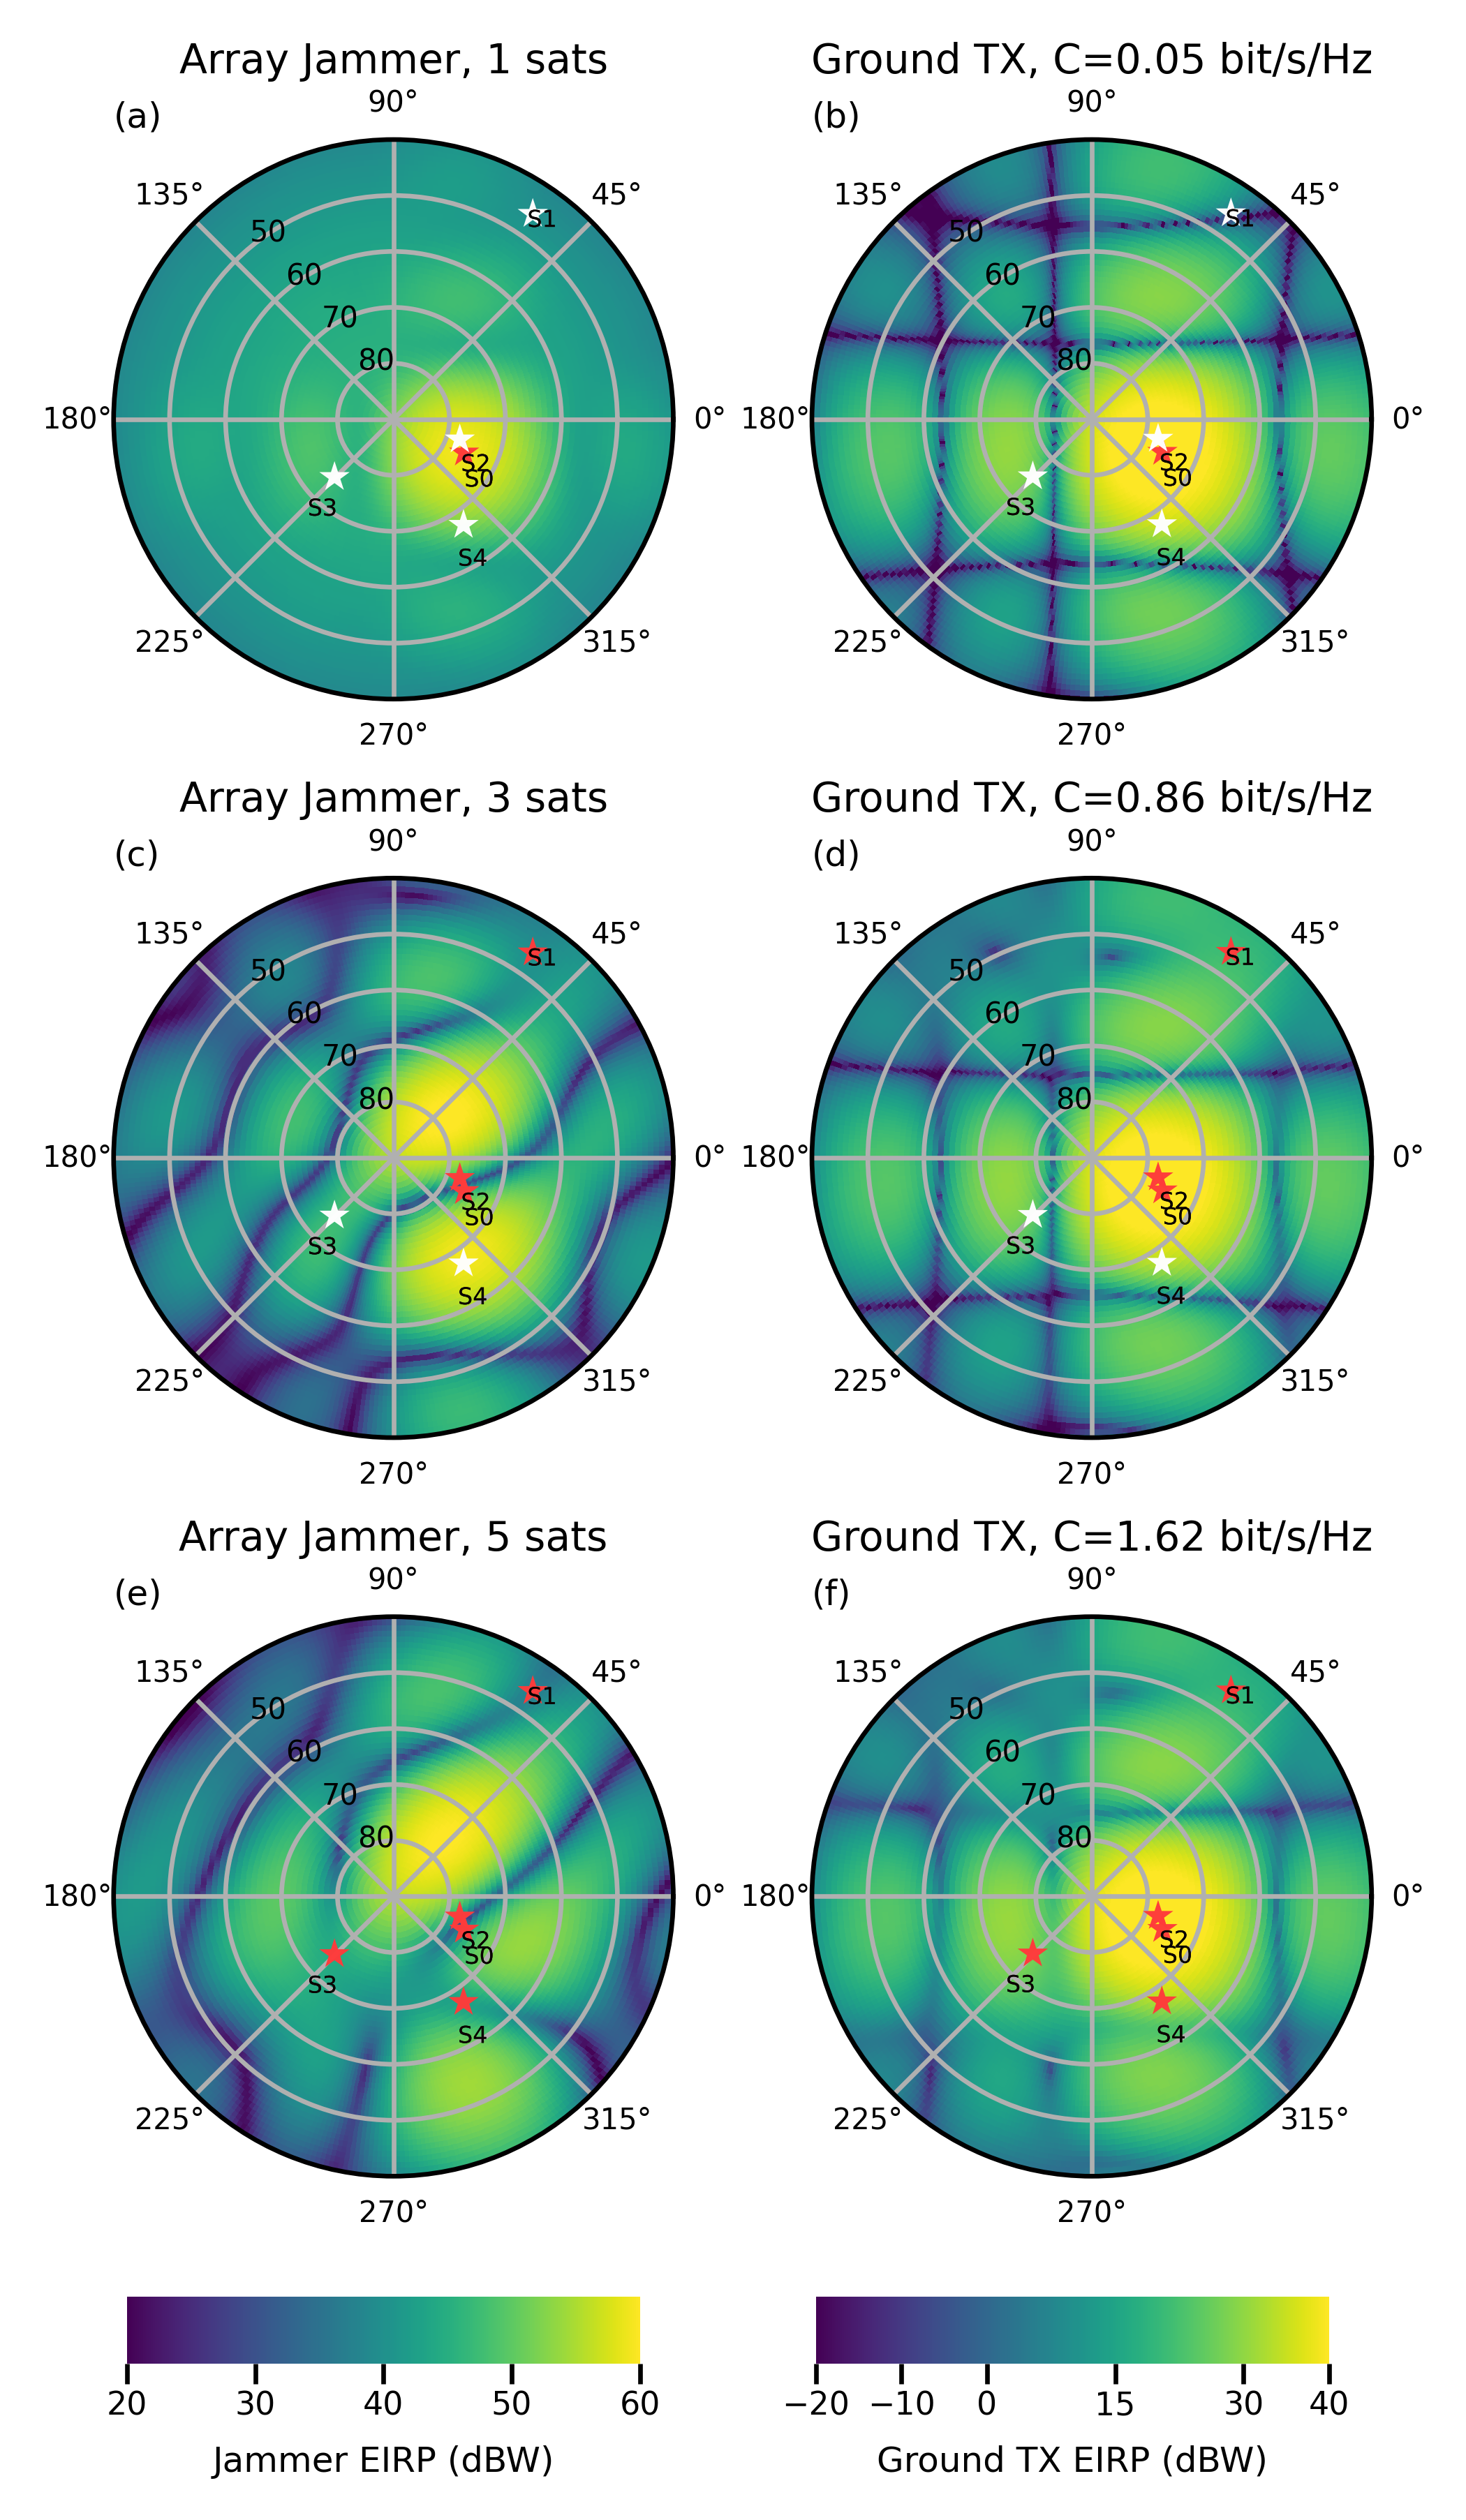

[plot] saved result_plot/radiomap_3x2_8.png and result_plot/radiomap_3x2_8.pdf


In [20]:
def plot_from_Qcache_dbw_ieee_3row2col_bottomLRcb(
    cache_path,
    *, save_dir="result_plot", fname_base="radiomap_3row2col_dbw_ieee_bottomLRcb",
    cmap="viridis",
    tx_Gmax=8.0, jam_Gmax=8.0,
    tx_colorbar_range=None, jam_colorbar_range=None,
    tx_cbar_ticks=None, jam_cbar_ticks=None,
    az_grid=np.linspace(0,360,361), el_grid=np.linspace(40,90,51),
    ref_power_watt=1.0,
    fig_width_in=3.5, fig_height_in=6.6, dpi=600,
    base_font=6, tick_font=5.5, title_font=7,
    rlim=(90,40), rticks=(50,60,70,80), rlabel_theta=130, rlabel_pad=-6,
    thetagrid_step=45, thetagrid_frac=0.92, thetagrid_pad=-5,
    tick_labelsize_r=5.0, tick_labelsize_theta=5.0,
):
    import matplotlib as mpl
    from matplotlib.ticker import FormatStrFormatter

    mpl.rcParams.update({
        "figure.dpi": dpi, "savefig.dpi": dpi,
        "pdf.fonttype": 42, "ps.fonttype": 42,
        "font.size": base_font, "axes.titlesize": title_font,
        "axes.labelsize": base_font, "xtick.labelsize": tick_font,
        "ytick.labelsize": tick_font, "legend.fontsize": base_font,
        "lines.linewidth": 0.6,
    })

    # ---- Load cache ----
    data = np.load(cache_path, allow_pickle=True)
    ks = data["ks"].astype(int)
    Q0_list = [np.asarray(Q0, dtype=complex) for Q0 in data["Q0_list"]]
    Q1_list = [np.asarray(Q1, dtype=complex) for Q1 in data["Q1_list"]]
    C_arr   = data["C_arr"]
    tx_rows, tx_cols = int(data["tx_rows"]), int(data["tx_cols"])
    jam_rows, jam_cols = int(data["jam_rows"]), int(data["jam_cols"])
    gnd_positions, sat_positions = data["gnd_positions"], data["sat_positions"]
    frequency_hz = float(data["frequency_hz"])

    sat_tx_markers  = make_sat_azel_for_tx_math(gnd_positions[0], sat_positions, frequency_hz)
    sat_jam_markers = make_sat_azel_for_tx_math(gnd_positions[1], sat_positions, frequency_hz)
    tx_elem_fn  = lambda az,el: tr38901_elem_gain_db_centered(az,el,0.0,90.0,Gmax=tx_Gmax)
    jam_elem_fn = lambda az,el: tr38901_elem_gain_db_centered(az,el,0.0,90.0,Gmax=jam_Gmax)

    P0_dbw_stack = np.stack([spatial_power_map_dbw(Q0, tx_rows, tx_cols, az_grid, el_grid,
                                                   tx_elem_fn, ref_power_watt=ref_power_watt)
                             for Q0 in Q0_list])
    P1_dbw_stack = np.stack([spatial_power_map_dbw(Q1, jam_rows, jam_cols, az_grid, el_grid,
                                                   jam_elem_fn, ref_power_watt=ref_power_watt)
                             for Q1 in Q1_list])

    if tx_colorbar_range is None:
        vmin_tx, vmax_tx = np.nanmin(P0_dbw_stack), np.nanmax(P0_dbw_stack)
    else:
        vmin_tx, vmax_tx = tx_colorbar_range
    if jam_colorbar_range is None:
        vmin_jm, vmax_jm = np.nanmin(P1_dbw_stack), np.nanmax(P1_dbw_stack)
    else:
        vmin_jm, vmax_jm = jam_colorbar_range

    # ---- 3 rows × 2 cols ----
    fig = plt.figure(figsize=(fig_width_in, fig_height_in))
    gs = fig.add_gridspec(
        3, 2,
        left=0.10, right=0.98, top=0.96, bottom=0.20,
        wspace=0.18, hspace=0.32
    )
    axes = [[fig.add_subplot(gs[r, c], projection="polar") for c in range(2)] for r in range(3)]

    def style_and_plot(ax, P_dbw, vmin, vmax, title, sat_list, n_highlight):
        im = _polar_panel(ax, P_dbw, az_grid, el_grid,
                          sat_list=sat_list, n_highlight=n_highlight,
                          title=title, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_rlim(*rlim)
        ax.set_rticks(list(rticks))
        ax.set_rlabel_position(rlabel_theta)
        ax.tick_params(axis='y', pad=rlabel_pad, labelsize=tick_labelsize_r)
        angles = np.arange(0, 360, thetagrid_step)
        try:
            ax.set_thetagrids(angles, frac=thetagrid_frac)
        except (TypeError, AttributeError):
            ax.set_thetagrids(angles)
        ax.tick_params(axis='x', pad=thetagrid_pad, labelsize=tick_labelsize_theta)
        ax.set_title(title, va="bottom", fontsize=title_font, pad=1.2)
        return im

    ims_left, ims_right = [], []
    for row, k in enumerate(ks):
        imL = style_and_plot(
            axes[row][0], P1_dbw_stack[row], vmin_jm, vmax_jm,
            title=f"Array Jammer, {int(k)} sats",
            sat_list=sat_jam_markers, n_highlight=int(k)
        )
        ims_left.append(imL)
        imR = style_and_plot(
            axes[row][1], P0_dbw_stack[row], vmin_tx, vmax_tx,
            title=f"Ground TX, C={float(C_arr[row]):.2f} bit/s/Hz",
            sat_list=sat_tx_markers, n_highlight=int(k)
        )
        ims_right.append(imR)


    panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    axes_flat = [axes[0][0], axes[0][1], axes[1][0], axes[1][1], axes[2][0], axes[2][1]]

    for label, ax in zip(panel_labels, axes_flat):
        ax.text(
            0.00, 1.01, label,          # 稍微在绘图区上方，避免压到极坐标外圈
            transform=ax.transAxes,
            ha='left', va='bottom',
            fontsize=base_font,          # 与图内字号一致；如需更小可用 base_font-1
            color='black',
            zorder=10                    # 确保在最上层
        )


    # ---- Bottom: Left & Right horizontal colorbars ----
    cax_jam = fig.add_axes([0.12, 0.13, 0.35, 0.025])  # 左
    cax_tx  = fig.add_axes([0.59, 0.13, 0.35, 0.025])  # 右

    cbar_jam = fig.colorbar(ims_left[0], cax=cax_jam, orientation="horizontal")
    cbar_tx  = fig.colorbar(ims_right[0], cax=cax_tx, orientation="horizontal")
    cbar_jam.set_label("Jammer EIRP (dBW)", fontsize=base_font)
    cbar_tx.set_label("Ground TX EIRP (dBW)", fontsize=base_font)
    cbar_jam.outline.set_linewidth(0)
    cbar_tx.outline.set_linewidth(0)
    for cb in (cbar_jam, cbar_tx):
        cb.ax.tick_params(labelsize=tick_font, pad=1)
        # cb.outline.set_linewidth(0.5)
    if jam_cbar_ticks is not None: cbar_jam.set_ticks(jam_cbar_ticks)
    if tx_cbar_ticks  is not None: cbar_tx.set_ticks(tx_cbar_ticks)

    # ---- Save ----
    out_dir = Path(save_dir); out_dir.mkdir(parents=True, exist_ok=True)
    out_png = out_dir / f"{fname_base}.png"
    out_pdf = out_dir / f"{fname_base}.pdf"
    fig.savefig(out_png, dpi=dpi, bbox_inches="tight")
    fig.savefig(out_pdf, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"[plot] saved {out_png} and {out_pdf}")
plot_from_Qcache_dbw_ieee_3row2col_bottomLRcb(
    cache_path,
    save_dir="result_plot",
    fname_base="radiomap_3x2_8",
    cmap="viridis",
    tx_colorbar_range=(-20, 40),
    tx_cbar_ticks=([ -20, -10,0,15,30,40]),
    jam_colorbar_range=(20, 60),
    jam_cbar_ticks=([ 20,30, 40, 50,60]),
    fig_width_in=3.5,    # 单列宽
    fig_height_in=6.4,   # 三行图稍高一些
    thetagrid_frac=0.90, thetagrid_pad=-4.2,
)
